# Data Imputation for 2023 IWALK Contest Data

This dataset contains daily step data of 301 participants during the 2023 IWalk contest period from May 1st 2023 to Aug 31st 2023 . There are missing data during the baseline period of May 1st to May 31st and during the contest period from June 1st to August 31st that we will impute. This notebook compares the performance of two methods of data imputation by analyzing differences in the distribution of average step data before and after the imputation. Finally, we test for statistical significance between the average daily step count before and after the contest to show if the participants' average daily step count increased after the intervention. 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import skew, kurtosis
import seaborn as sns
import missingno as msno

#worksheet with deduped, de-ided step data 
stepsdata_path = ("/Users/tanvitilloo/Desktop/SF Civic Tech/intentional-walk-analysis/App_DataRaw.xlsx")  
stepdata_raw = pd.read_excel(stepsdata_path)

In [8]:
stepdata_raw.shape #show number of rows and columns

(301, 123)

In [10]:
stepdata_raw.columns #show column names

DatetimeIndex(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04',
               '2023-05-05', '2023-05-06', '2023-05-07', '2023-05-08',
               '2023-05-09', '2023-05-10',
               ...
               '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25',
               '2023-08-26', '2023-08-27', '2023-08-28', '2023-08-29',
               '2023-08-30', '2023-08-31'],
              dtype='datetime64[ns]', length=123, freq=None)

In [12]:
stepdata_raw.columns = pd.to_datetime(stepdata_raw.columns).strftime('%Y-%m-%d') #remove time from column names
stepdata_raw.columns 

Index(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
       '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
       ...
       '2023-08-22', '2023-08-23', '2023-08-24', '2023-08-25', '2023-08-26',
       '2023-08-27', '2023-08-28', '2023-08-29', '2023-08-30', '2023-08-31'],
      dtype='object', length=123)

In [14]:
stepdata_raw.dtypes #show data type of columns

2023-05-01    float64
2023-05-02    float64
2023-05-03    float64
2023-05-04    float64
2023-05-05    float64
               ...   
2023-08-27    float64
2023-08-28    float64
2023-08-29    float64
2023-08-30    float64
2023-08-31    float64
Length: 123, dtype: object

In [16]:
stepdata_raw.isna().sum() #total number of missing values per column

2023-05-01     43
2023-05-02     43
2023-05-03     42
2023-05-04     44
2023-05-05     43
             ... 
2023-08-27    199
2023-08-28    202
2023-08-29    209
2023-08-30    208
2023-08-31    256
Length: 123, dtype: int64

As we can see, we have missing data for every day of the baseline and contest period. Thus, we first collect the count of missing data per user in a variable. Then we filter the dataset by removing users who have more than 25 percent of missing data during baseline and contest period. 

In [19]:
missing_data_count = stepdata_raw.isna().sum(axis = 1) #total number of missing values per user

In [21]:
missing_data_count

0      100
1       24
2       49
3        0
4       64
      ... 
296      1
297      0
298     71
299      1
300      0
Length: 301, dtype: int64

In [23]:
baseline_columns = stepdata_raw.loc[:, "2023-05-01" : "2023-05-31"].columns
contest_columns = stepdata_raw.loc[:, "2023-06-01" : "2023-08-31"].columns

In [25]:
#removing users who have more than 25% of data missing during either baseline or contest period
stepdata_filtered = stepdata_raw.loc[
                         (stepdata_raw[baseline_columns].isna().mean(axis = 1) <= 0.25) &
                        (stepdata_raw[contest_columns].isna().mean(axis = 1) <= 0.25)
]
stepdata_filtered.shape

(126, 123)

In [27]:
stepdata_filtered.head(10)

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-26,2023-08-27,2023-08-28,2023-08-29,2023-08-30,2023-08-31
3,4930.0,29351.0,30457.0,25895.0,5528.0,17858.0,2879.0,3567.0,26381.0,21659.0,...,13341.0,25484.0,24971.0,21905.0,21560.0,2291.0,2989.0,387.0,23299.0,23534.0
5,3802.0,2655.0,2653.0,3209.0,247.0,80.0,527.0,1041.0,1581.0,3412.0,...,4232.0,6175.0,3086.0,3121.0,5402.0,2972.0,4501.0,5652.0,923.0,NaN
10,8953.0,4788.0,3025.0,NaN,9065.0,839.0,1297.0,9406.0,5441.0,8279.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,NaN
13,1855.0,2557.0,1634.0,5155.0,3287.0,2439.0,4916.0,3626.0,1677.0,2465.0,...,4557.0,3686.0,5706.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN
14,942.0,165.0,1239.0,4048.0,2635.0,2653.0,2724.0,525.0,617.0,1058.0,...,1985.0,1671.0,8111.0,3858.0,1429.0,1101.0,2556.0,1471.0,5606.0,NaN
16,2470.0,3745.0,3976.0,3203.0,2349.0,4475.0,1088.0,2605.0,3085.0,3698.0,...,4767.0,5045.0,3131.0,3372.0,11700.0,2065.0,3211.0,5831.0,3343.0,NaN
17,4168.0,1031.0,2154.0,4458.0,1710.0,4161.0,1495.0,4320.0,7021.0,2313.0,...,7027.0,9040.0,7620.0,10971.0,8807.0,3665.0,6630.0,6852.0,7886.0,NaN
18,1898.0,2744.0,3286.0,2246.0,3659.0,1687.0,4242.0,6451.0,5168.0,5367.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,7267.0,5774.0,6780.0,10771.0,5660.0,2167.0,5297.0,5666.0,11123.0,5065.0,...,15504.0,2610.0,5327.0,8376.0,1717.0,1050.0,7737.0,6543.0,5603.0,NaN
22,1647.0,5247.0,7655.0,7222.0,8142.0,4813.0,2333.0,2013.0,1106.0,10376.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
stepdata_filtered.isna().sum(axis = 1)

3       0
5       1
10     24
13      6
14      3
       ..
292     3
296     1
297     0
299     1
300     0
Length: 126, dtype: int64

In [31]:
#information on removed users
removed_users = stepdata_raw.index[
    (stepdata_raw[baseline_columns].isna().mean(axis=1) > 0.25) |
    (stepdata_raw[contest_columns].isna().mean(axis=1) > 0.25)
].tolist()
num_removed_users = len(removed_users)
total_users = len(stepdata_raw)
percentage_removed = (num_removed_users / total_users) * 100

print("List of removed users:", removed_users)
print("Number of users removed:", num_removed_users)
print("Percentage of users removed:", percentage_removed, "%")


List of removed users: [0, 1, 2, 4, 6, 7, 8, 9, 11, 12, 15, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 38, 39, 42, 43, 45, 46, 47, 50, 51, 57, 59, 60, 61, 63, 65, 72, 74, 76, 77, 78, 79, 86, 87, 88, 90, 91, 92, 94, 95, 98, 101, 103, 104, 105, 106, 108, 110, 111, 112, 117, 118, 119, 121, 123, 125, 126, 127, 129, 131, 133, 134, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 148, 149, 152, 154, 157, 160, 161, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 176, 178, 179, 183, 184, 185, 186, 187, 189, 192, 193, 196, 198, 199, 200, 201, 202, 203, 205, 209, 214, 216, 220, 221, 222, 223, 224, 227, 228, 229, 231, 235, 239, 241, 242, 244, 245, 247, 249, 250, 252, 253, 255, 257, 259, 260, 261, 263, 264, 265, 266, 267, 268, 269, 271, 272, 275, 278, 279, 280, 282, 286, 287, 289, 290, 291, 293, 294, 295, 298]
Number of users removed: 175
Percentage of users removed: 58.139534883720934 %


We dropped 175 observations or 58% of the original data to adhere to the 25% missing data rule. We will now perform imputation on this new dataset. 

## Baseline Data Imputation

We will first calculate the number of missing values in the baseline data and visualize them to see if any patterns emerge. 

In [36]:
baseline_df = stepdata_filtered.loc[:, "2023-05-01": "2023-05-31"] #subset the data by baseline month
b_missing_per_column = baseline_df.isna().sum() #calculate missing values per day
print("Missing values per column:\n", b_missing_per_column)

Missing values per column:
 2023-05-01    1
2023-05-02    1
2023-05-03    0
2023-05-04    1
2023-05-05    0
2023-05-06    0
2023-05-07    0
2023-05-08    0
2023-05-09    0
2023-05-10    0
2023-05-11    0
2023-05-12    0
2023-05-13    0
2023-05-14    1
2023-05-15    1
2023-05-16    1
2023-05-17    0
2023-05-18    0
2023-05-19    0
2023-05-20    0
2023-05-21    0
2023-05-22    0
2023-05-23    1
2023-05-24    0
2023-05-25    0
2023-05-26    0
2023-05-27    0
2023-05-28    0
2023-05-29    0
2023-05-30    1
2023-05-31    0
dtype: int64


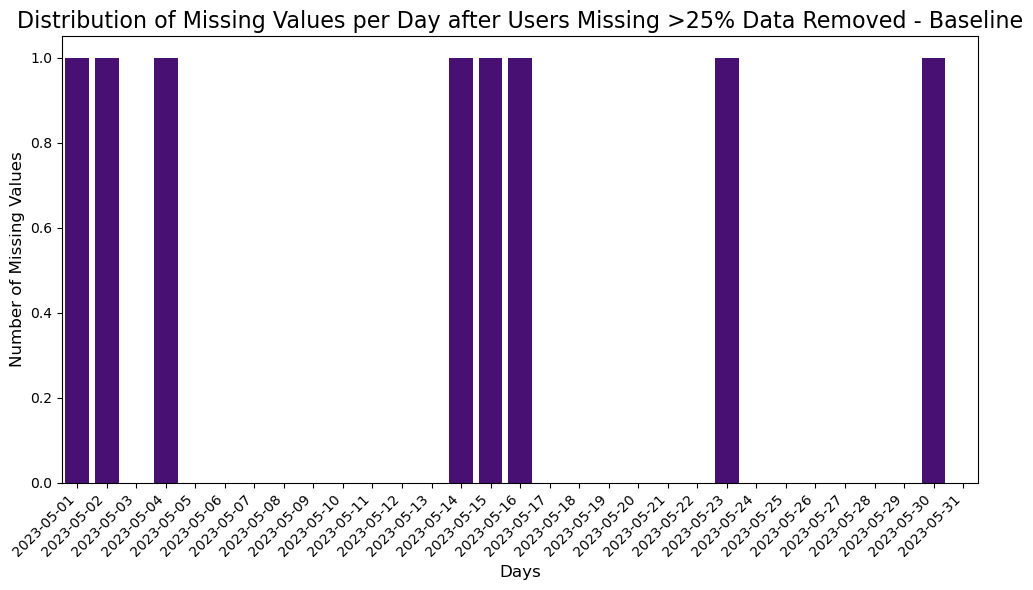

Maximum number of missing values in a single day: 1


In [38]:
# plots those values in a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=b_missing_per_column.index, y=b_missing_per_column.values, color="indigo")

plt.title('Distribution of Missing Values per Day after Users Missing >25% Data Removed - Baseline', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

max_missing_values = b_missing_per_column.max()
print("Maximum number of missing values in a single day:", max_missing_values)

In [39]:
b_missing_data_count = baseline_df.isna().sum(axis = 1) #calculate missing values per user 
b_missing_data_count.max()

2

As we can see, the maximum number of days a user is missing data is 2. Thus, using a mean imputation for this dataset should not be a cause for concern as we will not be imputing a lot of values. 

#### Mean Imputation

In [44]:
baseline_row_mean = baseline_df.mean(axis = 1) #calculate row mean on non-imputed data
baseline_row_mean

3      15839.580645
5       3416.935484
10      6483.600000
13      3928.354839
14      1979.677419
           ...     
292     1818.258065
296     7501.032258
297     6250.193548
299     7312.838710
300    19098.387097
Length: 126, dtype: float64

In [46]:
baseline_mean_impute_df = baseline_df.apply(lambda row: row.fillna(row.mean()), axis=1)

In [92]:
baseline_mean_impute_df.isna().sum() #check that the imputation worked 

2023-05-01             0
2023-05-02             0
2023-05-03             0
2023-05-04             0
2023-05-05             0
2023-05-06             0
2023-05-07             0
2023-05-08             0
2023-05-09             0
2023-05-10             0
2023-05-11             0
2023-05-12             0
2023-05-13             0
2023-05-14             0
2023-05-15             0
2023-05-16             0
2023-05-17             0
2023-05-18             0
2023-05-19             0
2023-05-20             0
2023-05-21             0
2023-05-22             0
2023-05-23             0
2023-05-24             0
2023-05-25             0
2023-05-26             0
2023-05-27             0
2023-05-28             0
2023-05-29             0
2023-05-30             0
2023-05-31             0
Average Daily Steps    0
dtype: int64

In [94]:
baseline_mean_impute_df["Average Daily Steps"] = baseline_mean_impute_df.mean(axis = 1) #calculate row mean on imputed data
baseline_mean_impute_df["Average Daily Steps"]

3      15839.580645
5       3416.935484
10      6483.600000
13      3928.354839
14      1979.677419
           ...     
292     1818.258065
296     7501.032258
297     6250.193548
299     7312.838710
300    19098.387097
Name: Average Daily Steps, Length: 126, dtype: float64

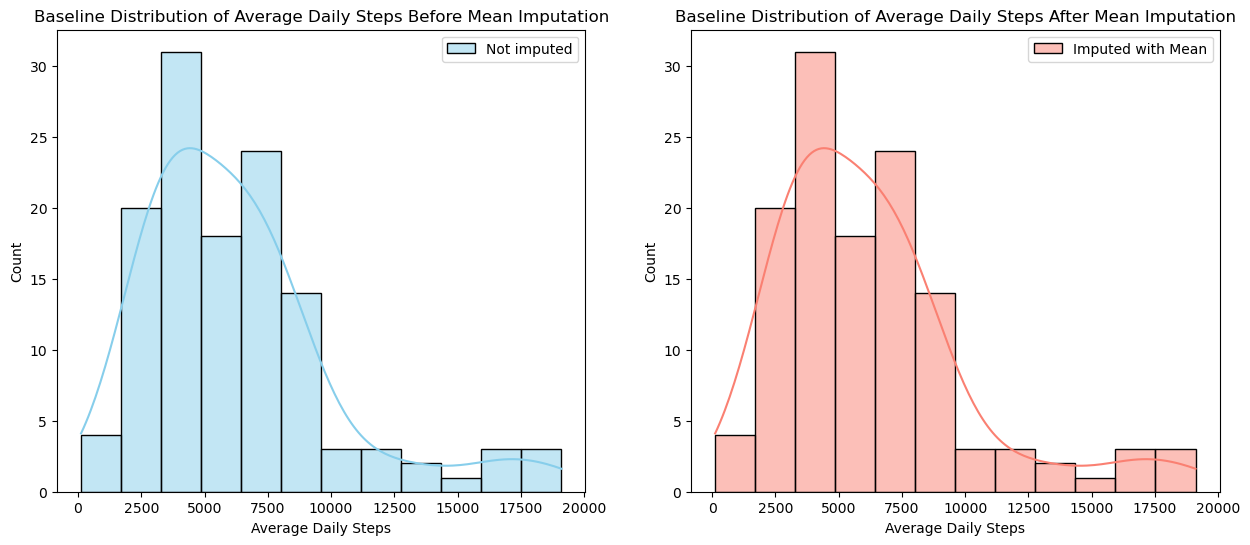

In [96]:
#plot the distribution of average daily steps before and after the imputation
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#Baseline average: Before mean imputation
sns.histplot(baseline_row_mean, label = "Not imputed", kde=True, color="skyblue", ax=ax[0])
ax[0].set_title("Baseline Distribution of Average Daily Steps Before Mean Imputation")
ax[0].legend()
ax[0].set_xlabel("Average Daily Steps")

#Baseline average: After mean imputation
sns.histplot(baseline_mean_impute_df["Average Daily Steps"], label = "Imputed with Mean", kde=True, color="salmon", ax=ax[1])
ax[1].set_title("Baseline Distribution of Average Daily Steps After Mean Imputation")
ax[1].legend()


In [98]:
notimputed_mean = round(baseline_row_mean.mean(), 2)
notimputed_variance = round(baseline_row_mean.var(), 2)
notimputed_std_dev = round(baseline_row_mean.std(), 2)

imputed_mean = round(baseline_mean_impute_df["Average Daily Steps"].mean(), 2)
imputed_variance = round(baseline_mean_impute_df["Average Daily Steps"].var(), 2)
imputed_std_dev = round(baseline_mean_impute_df["Average Daily Steps"].std(), 2)

# Print the results
print(f"Mean of Average Steps Before Imputation: {notimputed_mean}")
print(f"Mean of Average Steps After Imputation: {imputed_mean}")
print(f"Variance of Average Steps Before Imputation : {notimputed_variance}")
print(f"Variance of Average Steps After Imputation : {imputed_variance}")
print(f"Standard Deviation of Average Steps Before Imputation: {notimputed_std_dev}")
print(f"Standard Deviation of Average Steps After Imputation: {imputed_std_dev}")

Mean of Average Steps Before Imputation: 6257.54
Mean of Average Steps After Imputation: 6257.54
Variance of Average Steps Before Imputation : 14515523.35
Variance of Average Steps After Imputation : 14515523.35
Standard Deviation of Average Steps Before Imputation: 3809.92
Standard Deviation of Average Steps After Imputation: 3809.92


As we can see, the mean imputation does not change the distribution of average daily steps. This makes sense as the dataset after the filtering only contained a maximum of 1 missing value per day of the baseline period. 

### Contest Data Imputation

We will first calculate the number of missing values in the contest data and see if any patterns emerge 

In [100]:
contest_df = stepdata_filtered.loc[:, "2023-06-01": "2023-08-31"] #subset the data by baseline month
c_missing_per_column = contest_df.isna().sum() #calculate missing values per day
print("Missing values per column:\n", c_missing_per_column)

Missing values per column:
 2023-06-01     0
2023-06-02     0
2023-06-03     0
2023-06-04     0
2023-06-05     0
              ..
2023-08-27    35
2023-08-28    37
2023-08-29    44
2023-08-30    43
2023-08-31    87
Length: 92, dtype: int64


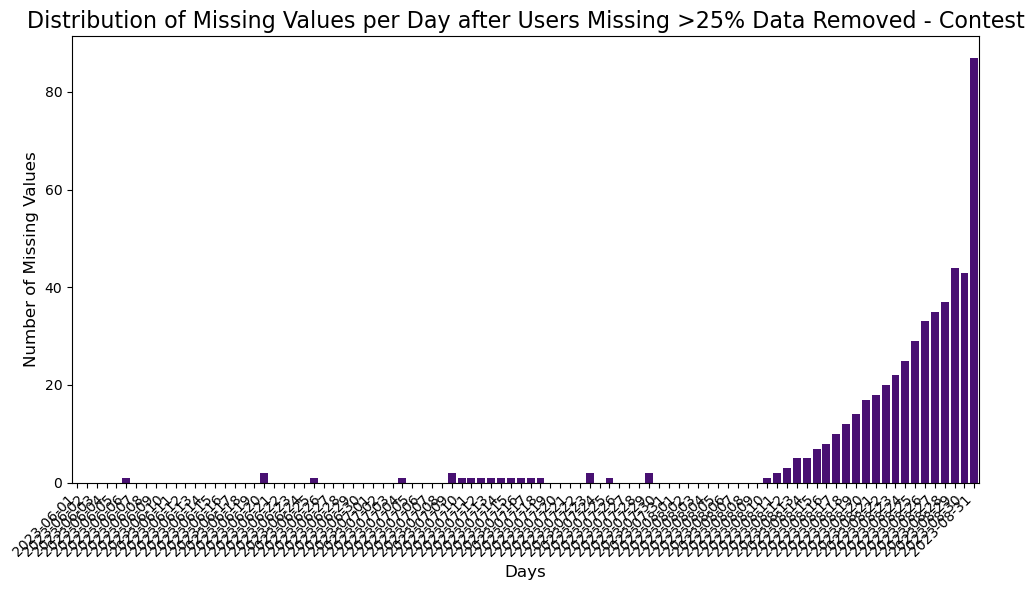

Maximum number of missing values in a single day: 87


In [102]:
# plots those values in a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=c_missing_per_column.index, y=c_missing_per_column.values, color="indigo")

plt.title('Distribution of Missing Values per Day after Users Missing >25% Data Removed - Contest', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

max_missing_values = c_missing_per_column.max()
print("Maximum number of missing values in a single day:", max_missing_values)

In [127]:
c_missing_data_count = contest_df.isna().sum(axis = 1) #calculate missing values per user 
c_missing_data_count

3       0
5       1
10     23
13      6
14      3
       ..
292     3
296     1
297     0
299     1
300     0
Length: 126, dtype: int64

As we can see, an increasing number of users have missing data towards the end of the contest. This has two implications - 1) Data are not missing at random 2) Using a method like back fill or forward fill is likely to skew the distribution of average daily steps for users with large amounts of missing data toward the end of the contest. 

We will first try the simplest approach of filling in missing values with the user's average daily steps over the number of days with available values. 

#### Mean Imputation

In [113]:
contest_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-26,2023-08-27,2023-08-28,2023-08-29,2023-08-30,2023-08-31
3,1628.0,2802.0,21968.0,23583.0,5649.0,26682.0,25961.0,3571.0,4919.0,21482.0,...,13341.0,25484.0,24971.0,21905.0,21560.0,2291.0,2989.0,387.0,23299.0,23534.0
5,2882.0,7223.0,4818.0,4001.0,7732.0,6731.0,4121.0,1727.0,3308.0,6800.0,...,4232.0,6175.0,3086.0,3121.0,5402.0,2972.0,4501.0,5652.0,923.0,NaN
10,8063.0,6442.0,3070.0,2259.0,1531.0,3439.0,4752.0,2087.0,2828.0,2638.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407.0,NaN
13,4210.0,4284.0,4616.0,4423.0,6208.0,4545.0,1401.0,4971.0,3226.0,1697.0,...,4557.0,3686.0,5706.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN
14,5240.0,5155.0,5069.0,953.0,5197.0,6945.0,3991.0,9201.0,7247.0,3071.0,...,1985.0,1671.0,8111.0,3858.0,1429.0,1101.0,2556.0,1471.0,5606.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,463.0,1510.0,1961.0,3203.0,2910.0,322.0,2717.0,1661.0,456.0,1940.0,...,744.0,2313.0,859.0,309.0,415.0,1400.0,688.0,NaN,NaN,NaN
296,9119.0,9085.0,1164.0,4159.0,13396.0,7276.0,13186.0,10177.0,11086.0,2827.0,...,11775.0,8520.0,8455.0,11643.0,2478.0,3110.0,11227.0,10432.0,9494.0,NaN
297,7725.0,7746.0,2379.0,350.0,11671.0,8195.0,7589.0,8790.0,10151.0,2404.0,...,4246.0,7584.0,9723.0,12112.0,3957.0,4327.0,7347.0,4752.0,6028.0,1657.0
299,14235.0,7576.0,1662.0,11679.0,2206.0,2511.0,5703.0,5926.0,4908.0,10699.0,...,7167.0,5923.0,7251.0,7763.0,535.0,2382.0,6798.0,7533.0,5681.0,NaN


In [115]:
contest_row_mean = contest_df.mean(axis = 1) #calculate row mean on non-imputed data
contest_row_mean

3      16604.641304
5       4600.725275
10      4556.782609
13      3256.023256
14      4090.730337
           ...     
292     1819.146067
296     6870.208791
297     6467.326087
299     5397.483516
300    17921.750000
Length: 126, dtype: float64

In [117]:
contest_mean_impute_df = contest_df.apply(lambda row: row.fillna(row.mean()), axis=1)
contest_mean_impute_df.isna().sum() #check that the imputation worked

2023-06-01    0
2023-06-02    0
2023-06-03    0
2023-06-04    0
2023-06-05    0
             ..
2023-08-27    0
2023-08-28    0
2023-08-29    0
2023-08-30    0
2023-08-31    0
Length: 92, dtype: int64

In [119]:
contest_mean_impute_df

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-26,2023-08-27,2023-08-28,2023-08-29,2023-08-30,2023-08-31
3,1628.0,2802.0,21968.0,23583.0,5649.0,26682.0,25961.0,3571.0,4919.0,21482.0,...,13341.000000,25484.000000,24971.000000,21905.000000,21560.000000,2291.000000,2989.000000,387.000000,23299.000000,23534.000000
5,2882.0,7223.0,4818.0,4001.0,7732.0,6731.0,4121.0,1727.0,3308.0,6800.0,...,4232.000000,6175.000000,3086.000000,3121.000000,5402.000000,2972.000000,4501.000000,5652.000000,923.000000,4600.725275
10,8063.0,6442.0,3070.0,2259.0,1531.0,3439.0,4752.0,2087.0,2828.0,2638.0,...,4556.782609,4556.782609,4556.782609,4556.782609,4556.782609,4556.782609,4556.782609,4556.782609,407.000000,4556.782609
13,4210.0,4284.0,4616.0,4423.0,6208.0,4545.0,1401.0,4971.0,3226.0,1697.0,...,4557.000000,3686.000000,5706.000000,106.000000,3256.023256,3256.023256,3256.023256,3256.023256,3256.023256,3256.023256
14,5240.0,5155.0,5069.0,953.0,5197.0,6945.0,3991.0,9201.0,7247.0,3071.0,...,1985.000000,1671.000000,8111.000000,3858.000000,1429.000000,1101.000000,2556.000000,1471.000000,5606.000000,4090.730337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,463.0,1510.0,1961.0,3203.0,2910.0,322.0,2717.0,1661.0,456.0,1940.0,...,744.000000,2313.000000,859.000000,309.000000,415.000000,1400.000000,688.000000,1819.146067,1819.146067,1819.146067
296,9119.0,9085.0,1164.0,4159.0,13396.0,7276.0,13186.0,10177.0,11086.0,2827.0,...,11775.000000,8520.000000,8455.000000,11643.000000,2478.000000,3110.000000,11227.000000,10432.000000,9494.000000,6870.208791
297,7725.0,7746.0,2379.0,350.0,11671.0,8195.0,7589.0,8790.0,10151.0,2404.0,...,4246.000000,7584.000000,9723.000000,12112.000000,3957.000000,4327.000000,7347.000000,4752.000000,6028.000000,1657.000000
299,14235.0,7576.0,1662.0,11679.0,2206.0,2511.0,5703.0,5926.0,4908.0,10699.0,...,7167.000000,5923.000000,7251.000000,7763.000000,535.000000,2382.000000,6798.000000,7533.000000,5681.000000,5397.483516


In [72]:
contest_mean_impute_df["Average Daily Steps"] = contest_mean_impute_df.mean(axis = 1) #calculate row mean on imputed data
contest_mean_impute_df["Average Daily Steps"]

3      16604.641304
5       4600.725275
10      4556.782609
13      3256.023256
14      4090.730337
           ...     
292     1819.146067
296     6870.208791
297     6467.326087
299     5397.483516
300    17921.750000
Name: Average Daily Steps, Length: 126, dtype: float64

Mean of Average Steps Before Imputation: 7187.50478
Mean of Average Steps After Imputation: 7187.50478
Variance of Average Steps Before Imputation : 22907642.51514
Variance of Average Steps After Imputation : 22907642.51514
Standard Deviation of Average Steps Before Imputation: 4786.1929
Standard Deviation of Average Steps After Imputation: 4786.1929


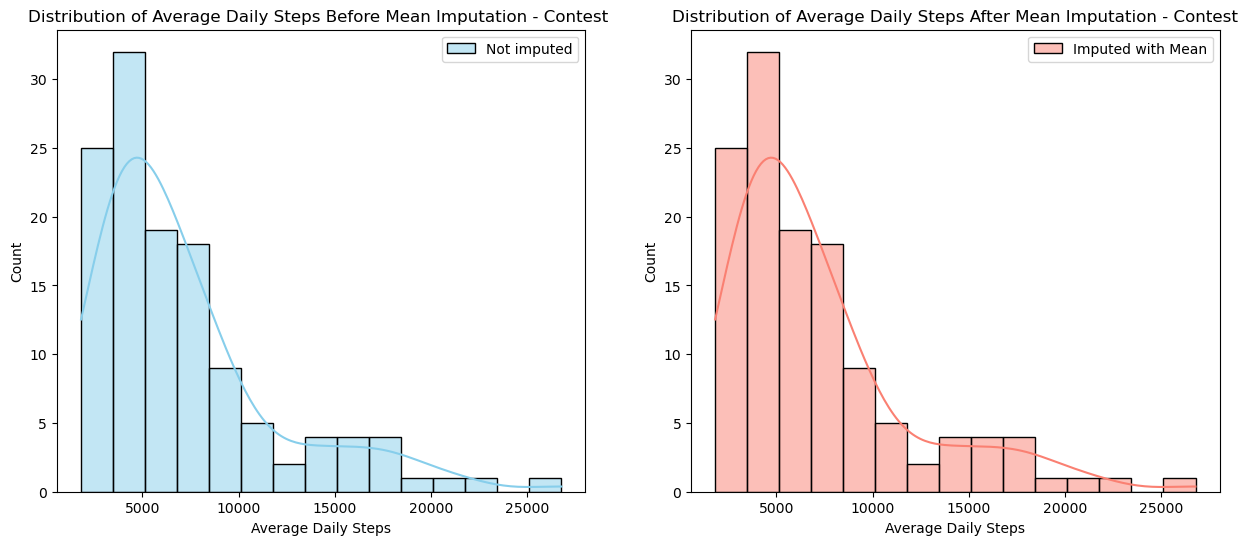

In [145]:
#plot the distribution of average daily steps before and after the imputation
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#Contest average: Before mean imputation
sns.histplot(contest_row_mean, label = "Not imputed", kde=True, color="skyblue", ax=ax[0])
ax[0].set_title("Distribution of Average Daily Steps Before Mean Imputation - Contest ")
ax[0].legend()
ax[0].set_xlabel("Average Daily Steps")
#ax[0].text("

#Contest average: After mean imputation
sns.histplot(contest_mean_impute_df["Average Daily Steps"], label = "Imputed with Mean", kde=True, color="salmon", ax=ax[1])
ax[1].set_title("Distribution of Average Daily Steps After Mean Imputation - Contest")
ax[1].legend()

c_notimputed_mean = round(contest_row_mean.mean(), 5)
c_notimputed_variance = round(contest_row_mean.var(), 5)
c_notimputed_std_dev = round(contest_row_mean.std(), 5)

c_mn_imputed_mean = round(contest_mean_impute_df["Average Daily Steps"].mean(), 5)
c_mn_imputed_variance = round(contest_mean_impute_df["Average Daily Steps"].var(), 5)
c_mn_imputed_std_dev = round(contest_mean_impute_df["Average Daily Steps"].std(), 5)

# Print the results
print(f"Mean of Average Steps Before Imputation: {c_notimputed_mean}")
print(f"Mean of Average Steps After Imputation: {c_mn_imputed_mean}")
print(f"Variance of Average Steps Before Imputation : {c_notimputed_variance}")
print(f"Variance of Average Steps After Imputation : {c_mn_imputed_variance}")
print(f"Standard Deviation of Average Steps Before Imputation: {c_notimputed_std_dev}")
print(f"Standard Deviation of Average Steps After Imputation: {c_mn_imputed_std_dev}")

The mean of the distribution remains the same after imputation. But we get lesser variation in the dataset by imputing missing values with the user's average daily steps. 

Next, we will try a median imputation 

#### Median Imputation

In [135]:
contest_median_impute_df = contest_df.apply(lambda row: row.fillna(row.median()), axis=1)
contest_median_impute_df.isna().sum() #check that the imputation worked

2023-06-01    0
2023-06-02    0
2023-06-03    0
2023-06-04    0
2023-06-05    0
             ..
2023-08-27    0
2023-08-28    0
2023-08-29    0
2023-08-30    0
2023-08-31    0
Length: 92, dtype: int64

In [137]:
contest_median_impute_df["Average Daily Steps"] = contest_median_impute_df.mean(axis = 1) #calculate row mean on imputed data
contest_median_impute_df["Average Daily Steps"]

3      16604.641304
5       4597.728261
10      4430.836957
13      3234.076087
14      4089.956522
           ...     
292     1819.532609
296     6873.380435
297     6467.326087
299     5392.163043
300    17921.750000
Name: Average Daily Steps, Length: 126, dtype: float64

Mean of Average Steps Before Imputation: 7187.5
Mean of Average Steps After Imputation: 7187.5
Variance of Average Steps Before Imputation : 22907642.52
Variance of Average Steps After Imputation : 14515523.35
Standard Deviation of Average Steps Before Imputation: 4786.19
Standard Deviation of Average Steps After Imputation: 3809.92


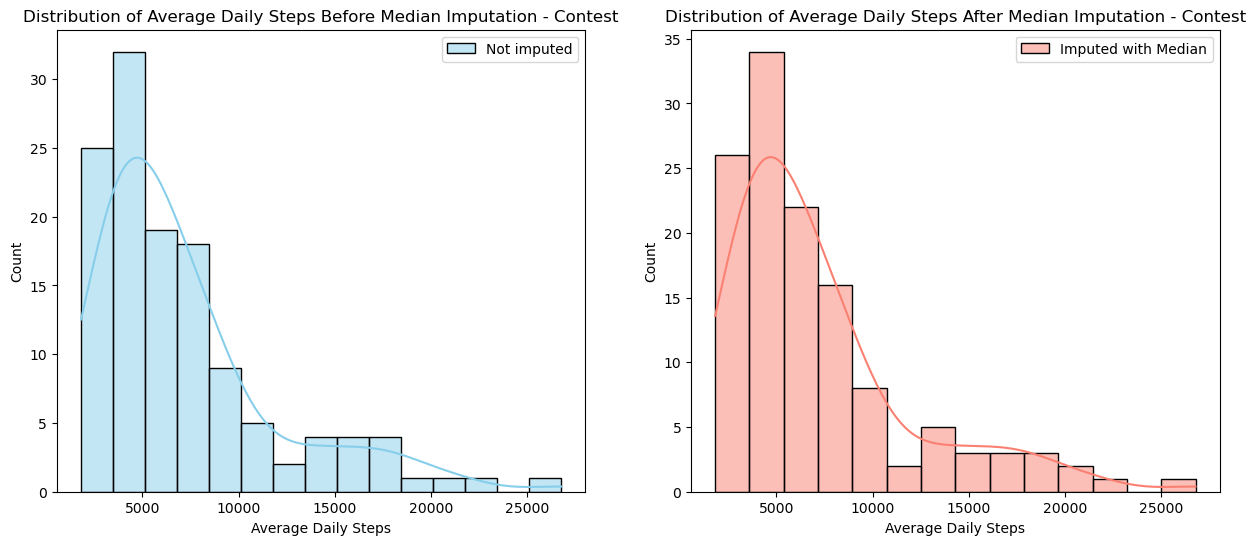

In [141]:
#plot the distribution of average daily steps before and after the imputation
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

#Contest average: Before mean imputation
sns.histplot(contest_row_mean, label = "Not imputed", kde=True, color="skyblue", ax=ax[0])
ax[0].set_title("Distribution of Average Daily Steps Before Median Imputation - Contest")
ax[0].legend()
ax[0].set_xlabel("Average Daily Steps")
#ax[0].text("

#Contest average: After mean imputation
sns.histplot(contest_median_impute_df["Average Daily Steps"], label = "Imputed with Median", kde=True, color="salmon", ax=ax[1])
ax[1].set_title("Distribution of Average Daily Steps After Median Imputation - Contest")
ax[1].legend()

c_notimputed_mean = round(contest_row_mean.mean(), 2)
c_notimputed_variance = round(contest_row_mean.var(), 2)
c_notimputed_std_dev = round(contest_row_mean.std(), 2)

c_md_imputed_mean = round(contest_mean_impute_df["Average Daily Steps"].mean(), 2)
c_md_imputed_variance = round(baseline_mean_impute_df["Average Daily Steps"].var(), 2)
c_md_imputed_std_dev = round(baseline_mean_impute_df["Average Daily Steps"].std(), 2)

# Print the results
print(f"Mean of Average Steps Before Imputation: {c_notimputed_mean}")
print(f"Mean of Average Steps After Imputation: {c_md_imputed_mean}")
print(f"Variance of Average Steps Before Imputation : {c_notimputed_variance}")
print(f"Variance of Average Steps After Imputation : {c_md_imputed_variance}")
print(f"Standard Deviation of Average Steps Before Imputation: {c_notimputed_std_dev}")
print(f"Standard Deviation of Average Steps After Imputation: {c_md_imputed_std_dev}")

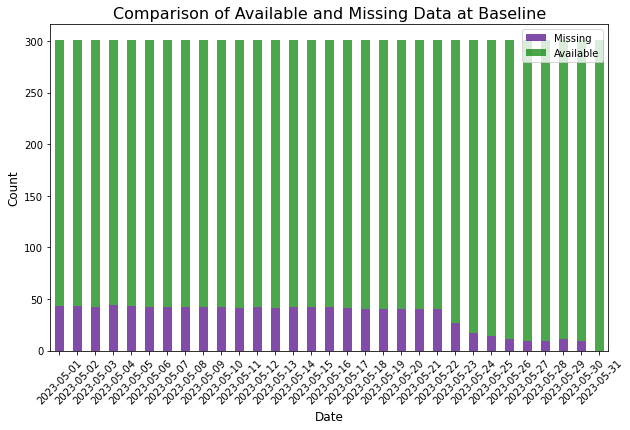

In [287]:
b_notmissing_per_column = baseline_df.notna().sum() #calculate total available values per day
#print("Available values per column:\n", b_notmissing_per_column)

b_missing_df = pd.DataFrame({      #create a df with count of missing and available values
    'Missing': b_missing_per_column,
    'Available': b_notmissing_per_column
})

b_missing_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['indigo', 'green'], alpha=0.7) 


plt.title('Comparison of Available and Missing Data at Baseline', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Missing', 'Available'], loc='upper right')
plt.show()

In [85]:
contest_df.isna().sum

,2023-06-01,2023-06-02,2023-06-03,2023-06-04,2023-06-05,2023-06-06,2023-06-07,2023-06-08,2023-06-09,2023-06-10,...,2023-08-22,2023-08-23,2023-08-24,2023-08-25,2023-08-26,2023-08-27,2023-08-28,2023-08-29,2023-08-30,2023-08-31
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
10,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,False,True
13,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
14,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


From the graphs we can see that every day of the baseline month has missing values and that there are fewer missing values at the end of the month than at the start of the month. We can also see that the proportion of missing values to available values stays roughly the same for all days except the last few. This allows us to proceed with imputing missing values since we have more available data for each individual than missing. The assumption here is that based on the observed daily steps we should be able to infer the number of daily steps for days that do not have data.

#### Baseline Average Daily Steps with Available Values 

We will now calculate the average number of daily steps by dividing the sum of available values in the row observations with the number of days in the baseline period. We then visualize the distribution of averages and get the moments of distribution.  

In [458]:
#compute row average including na observations 
baseline_df["Mean with values"] = (baseline_df.sum(axis=1) /baseline_df.shape[1]).round(3)

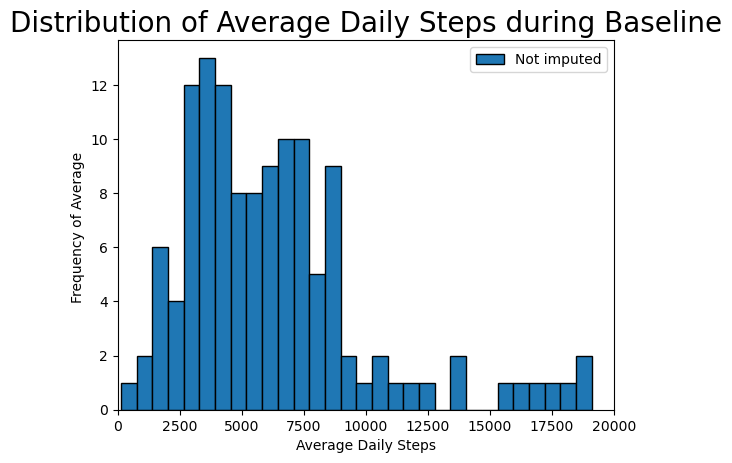

In [460]:
#plt.hist(baseline_df["Mean with values"], density=True)
num_bins = 30
plt.hist(baseline_df["Mean with values"], num_bins, density=False, label = "Not imputed",
                                edgecolor='k')
                            
plt.title('Distribution of Average Daily Steps during Baseline', fontsize=20)
plt.xlabel(r'Average Daily Steps')
plt.ylabel(r'Frequency of Average ')
plt.xlim([0, 20000])
plt.legend(loc = "upper right")

In [322]:
mean_with_values = round(baseline_df["Mean with values"].mean(), 3)
var_with_values = round(baseline_df["Mean with values"].var(), 3)
sd_with_values = round(baseline_df["Mean with values"].std(),3)
#mode_with_values = baseline_df["Mean with values"].mode(axis = 'columns')
#median_with_values = round(baseline_df["Median with values"].median(), 3)
print("Mean, variance, and standard error of this distribution are:")
print("Mean: " + str(mean_with_values))
print("Variance: " + str(var_with_values))
print("Standard Deviation: " + str(sd_with_values))
#print("Mode: " + str(mode_with_values))

Mean, variance, and standard error of this distribution are:
Mean: 4912.855
Variance: 12521843.19
Standard Deviation: 3538.622


As we can see from this graph, there is high variance in the average number of daily steps with the mean being 4913 steps a day. Majority of the averages lie below 10,000 steps a day and there are a few outlier observations that have 15,000 to 20,000 average daily steps. 

The goal of our imputation will be to retain this distribution of average daily steps after the imputation. Hence, we will use moments of distribution like mean, variance, and standard variance to compare the new dataset with imputed daily steps to the original baseline datasee with missing values.

#### Imputing Missing Data with Mean

This method uses the row mean to fill in the missing values for each observation. In other words, we use the individual's baseline average daily number of steps to fill the values for days with missing data.

In [377]:
baseline_df.columns

Index(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
       '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
       '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15',
       '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20',
       '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
       '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30',
       '2023-05-31', 'Mean with values'],
      dtype='object')

In [378]:
baseline_df.isna()

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [379]:
b_mean_impute_df = baseline_df.copy() #copy the baseline data

#Imputing with row means
for col in b_mean_impute_df.columns[:-1]: #for all columns except the mean column
    b_mean_impute_df[col] =  b_mean_impute_df[col].fillna(b_mean_impute_df['Mean with values']) 
    #fill missing values with the row means 

In [380]:
b_mean_impute_df.isna().sum() #check if there are still missing values

2023-05-01          0
2023-05-02          0
2023-05-03          0
2023-05-04          0
2023-05-05          0
2023-05-06          0
2023-05-07          0
2023-05-08          0
2023-05-09          0
2023-05-10          0
2023-05-11          0
2023-05-12          0
2023-05-13          0
2023-05-14          0
2023-05-15          0
2023-05-16          0
2023-05-17          0
2023-05-18          0
2023-05-19          0
2023-05-20          0
2023-05-21          0
2023-05-22          0
2023-05-23          0
2023-05-24          0
2023-05-25          0
2023-05-26          0
2023-05-27          0
2023-05-28          0
2023-05-29          0
2023-05-30          0
2023-05-31          0
Mean with values    0
dtype: int64

In [381]:
baseline_df.isna()#check if original baseline data still has missing values

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [382]:
b_mean_impute_df.head(10)

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values
0,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,...,45.000,3099.000,1339.000,4193.000,6350.0,6415.0,3911.0,3275.0,3570,1038.613
1,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,...,950.032,950.032,3170.000,5205.000,3098.0,4481.0,2910.0,3568.0,7019,950.032
2,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,...,1212.226,1212.226,1212.226,1212.226,9965.0,24058.0,1967.0,1065.0,524,1212.226
3,4930.000,29351.000,30457.000,25895.000,5528.000,17858.000,2879.000,3567.000,26381.000,21659.000,...,27183.000,21784.000,1323.000,22493.000,32316.0,17272.0,2427.0,25778.0,25065,15839.581
4,3222.000,5197.000,4490.000,4124.000,2107.000,7063.000,3905.000,3479.000,4723.000,4692.000,...,7182.000,2738.000,5379.000,13257.000,3564.0,5404.0,2841.0,286.0,4630,4946.194
5,3802.000,2655.000,2653.000,3209.000,247.000,80.000,527.000,1041.000,1581.000,3412.000,...,6171.000,4034.000,3145.000,8659.000,7306.0,2682.0,5044.0,1532.0,6771,3416.935
6,1322.000,1136.000,1119.000,2452.000,1354.000,3163.000,1097.000,1039.000,955.000,1399.000,...,973.000,1335.000,1211.000,1076.000,4049.0,3147.0,1307.0,1082.0,1212,1721.387
7,392.000,191.000,1126.000,3447.000,2129.000,741.000,2747.000,376.000,3142.000,489.000,...,2952.000,2893.000,3674.000,4352.000,4058.0,2579.0,1171.0,1914.0,1540,2377.194
8,3205.000,5516.000,3696.000,6920.000,7326.000,3799.000,6821.000,7552.000,1678.000,6647.000,...,4833.000,4894.000,4442.000,5959.000,2999.0,9329.0,6049.0,2711.0,5053,5305.419
9,4691.000,4516.000,6834.000,5044.000,4602.000,8291.000,6263.000,5622.000,7203.000,3721.000,...,5948.000,7878.000,2248.000,628.000,161.0,1599.0,2361.0,2607.0,6471,4982.677


In [383]:
b_mean_impute_df.drop("Mean with values", axis = 1, inplace = True )

b_mean_impute_df["Baseline Average Steps Per Day"] = (b_mean_impute_df.sum(axis=1) /b_mean_impute_df.shape[1]).round(3)
#compute row averages on imputed data

b_mean_impute_df.head(10)

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Baseline Average Steps Per Day
0,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,1038.613,...,45.000,3099.000,1339.000,4193.000,6350.0,6415.0,3911.0,3275.0,3570,1775.693
1,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,950.032,...,950.032,950.032,3170.000,5205.000,3098.0,4481.0,2910.0,3568.0,7019,1685.541
2,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,1212.226,...,1212.226,1212.226,1212.226,1212.226,9965.0,24058.0,1967.0,1065.0,524,2228.931
3,4930.000,29351.000,30457.000,25895.000,5528.000,17858.000,2879.000,3567.000,26381.000,21659.000,...,27183.000,21784.000,1323.000,22493.000,32316.0,17272.0,2427.0,25778.0,25065,15839.581
4,3222.000,5197.000,4490.000,4124.000,2107.000,7063.000,3905.000,3479.000,4723.000,4692.000,...,7182.000,2738.000,5379.000,13257.000,3564.0,5404.0,2841.0,286.0,4630,4946.194
5,3802.000,2655.000,2653.000,3209.000,247.000,80.000,527.000,1041.000,1581.000,3412.000,...,6171.000,4034.000,3145.000,8659.000,7306.0,2682.0,5044.0,1532.0,6771,3416.935
6,1322.000,1136.000,1119.000,2452.000,1354.000,3163.000,1097.000,1039.000,955.000,1399.000,...,973.000,1335.000,1211.000,1076.000,4049.0,3147.0,1307.0,1082.0,1212,1721.387
7,392.000,191.000,1126.000,3447.000,2129.000,741.000,2747.000,376.000,3142.000,489.000,...,2952.000,2893.000,3674.000,4352.000,4058.0,2579.0,1171.0,1914.0,1540,2377.194
8,3205.000,5516.000,3696.000,6920.000,7326.000,3799.000,6821.000,7552.000,1678.000,6647.000,...,4833.000,4894.000,4442.000,5959.000,2999.0,9329.0,6049.0,2711.0,5053,5305.419
9,4691.000,4516.000,6834.000,5044.000,4602.000,8291.000,6263.000,5622.000,7203.000,3721.000,...,5948.000,7878.000,2248.000,628.000,161.0,1599.0,2361.0,2607.0,6471,4982.677


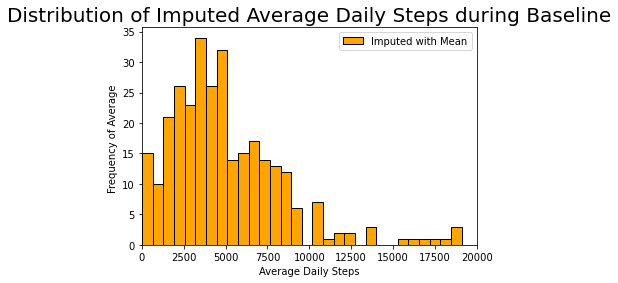

In [349]:
#plt.hist(baseline_df["Mean with values"], density=True)
num_bins = 30
plt.hist(b_mean_impute_df["Baseline Average Steps Per Day"], num_bins, density=False, label = "Imputed with Mean", color = "orange",
                                edgecolor='k')
                            
plt.title('Distribution of Imputed Average Daily Steps during Baseline', fontsize=20)
plt.xlabel(r'Average Daily Steps')
plt.ylabel(r'Frequency of Average ')
plt.xlim([0, 20000]) 
plt.legend(loc='upper right')

In [332]:
mean_with_meanimpute = round(b_mean_impute_df["Baseline Average Steps Per Day"].mean(), 3)
var_with_meanimpute = round(b_mean_impute_df["Baseline Average Steps Per Day"].var(), 3)
sd_with_meanimpute = round(b_mean_impute_df["Baseline Average Steps Per Day"].std(),3)
#median_with_values = round(baseline_df["Median with values"].median(), 3)
print("Mean, variance, and standard error of this distribution are:")
print("Mean: " + str(mean_with_meanimpute))
print("Variance: " + str(var_with_meanimpute))
print("Standard Deviation: " + str(sd_with_meanimpute))

Mean, variance, and standard error of this distribution are:
Mean: 5014.369
Variance: 12044123.696
Standard Deviation: 3470.464


In [333]:
print("Absolute difference in mean: " + str(np.abs(mean_with_meanimpute - mean_with_values)))
print("Absolute difference in variance: " + str(np.abs(var_with_meanimpute - var_with_values)))
print("Absolute difference in standard deviation: " + str(np.abs(sd_with_meanimpute - sd_with_values)))

Absolute difference in mean: 101.51400000000012
Absolute difference in variance: 477719.493999999
Absolute difference in standard deviation: 68.1579999999999


From the graph, we can see that imputing with the mean of an individual's daily steps retains the shape of the original distribution. The absolute differences in the mean of the imputed dataset and the original dataset is 101 steps.

#### Imputing Missing Data with Median

This method uses the median of the row observation to fill in missing values. In other words, we use the middle point of an individual's total number of steps walked during the baseline period to fill in values for days with missing data.

In [441]:
b_median_impute_df = baseline_df.copy()
b_median_impute_df.columns
b_median_impute_df.isna()

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [427]:
#baseline_df.isna()

In [428]:
b_median_impute_df.columns

Index(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
       '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
       '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15',
       '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20',
       '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
       '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30',
       '2023-05-31', 'Mean with values'],
      dtype='object')

In [442]:
#compute row median for all columns except mean column
b_median_impute_df["Median with values"] = b_median_impute_df.iloc[:, :-1].median(axis=1) 
b_median_impute_df.head(5)
    

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values,Median with values
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3099.0,1339.0,4193.0,6350.0,6415.0,3911.0,3275.0,3570,1038.613,3570.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3170.0,5205.0,3098.0,4481.0,2910.0,3568.0,7019,950.032,3568.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9965.0,24058.0,1967.0,1065.0,524,1212.226,1967.0
3,4930.0,29351.0,30457.0,25895.0,5528.0,17858.0,2879.0,3567.0,26381.0,21659.0,...,21784.0,1323.0,22493.0,32316.0,17272.0,2427.0,25778.0,25065,15839.581,19012.0
4,3222.0,5197.0,4490.0,4124.0,2107.0,7063.0,3905.0,3479.0,4723.0,4692.0,...,2738.0,5379.0,13257.0,3564.0,5404.0,2841.0,286.0,4630,4946.194,4490.0


Here we have the median for each row with missing values included in the median calculation. We will now use this median to impute missing data in each row. 

In [443]:
#Imputing with row median
for col in b_median_impute_df.columns[:-2]: #for all columns except the mean & median column
    b_median_impute_df[col] =  b_median_impute_df[col].fillna(b_median_impute_df['Median with values'])#fill missing values with the row median 
   

In [444]:
b_median_impute_df.isna()#check if there are still missing values

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values,Median with values
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [432]:
baseline_df.isna() #check if original baseline data still has missing values 

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Mean with values
0,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,True,True,True,True,True,True,True,True,True,True,...,True,True,False,False,False,False,False,False,False,False
2,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [445]:
b_median_impute_df.columns

Index(['2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04', '2023-05-05',
       '2023-05-06', '2023-05-07', '2023-05-08', '2023-05-09', '2023-05-10',
       '2023-05-11', '2023-05-12', '2023-05-13', '2023-05-14', '2023-05-15',
       '2023-05-16', '2023-05-17', '2023-05-18', '2023-05-19', '2023-05-20',
       '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24', '2023-05-25',
       '2023-05-26', '2023-05-27', '2023-05-28', '2023-05-29', '2023-05-30',
       '2023-05-31', 'Mean with values', 'Median with values'],
      dtype='object')

In [446]:
#drop the columns with row mean and median
b_median_impute_df = b_median_impute_df.drop(columns=["Mean with values", "Median with values"]) 


In [447]:
b_median_impute_df["Baseline Average Steps Per Day"] = (b_median_impute_df.sum(axis=1) /b_median_impute_df.shape[1]).round(3)
#compute row averages on imputed data

In [448]:
b_median_impute_df.head(5)

,2023-05-01,2023-05-02,2023-05-03,2023-05-04,2023-05-05,2023-05-06,2023-05-07,2023-05-08,2023-05-09,2023-05-10,...,2023-05-23,2023-05-24,2023-05-25,2023-05-26,2023-05-27,2023-05-28,2023-05-29,2023-05-30,2023-05-31,Baseline Average Steps Per Day
0,3570.0,3570.0,3570.0,3570.0,3570.0,3570.0,3570.0,3570.0,3570.0,3570.0,...,45.0,3099.0,1339.0,4193.0,6350.0,6415.0,3911.0,3275.0,3570,3572.161
1,3568.0,3568.0,3568.0,3568.0,3568.0,3568.0,3568.0,3568.0,3568.0,3568.0,...,3568.0,3568.0,3170.0,5205.0,3098.0,4481.0,2910.0,3568.0,7019,3712.355
2,1967.0,1967.0,1967.0,1967.0,1967.0,1967.0,1967.0,1967.0,1967.0,1967.0,...,1967.0,1967.0,1967.0,1967.0,9965.0,24058.0,1967.0,1065.0,524,2861.968
3,4930.0,29351.0,30457.0,25895.0,5528.0,17858.0,2879.0,3567.0,26381.0,21659.0,...,27183.0,21784.0,1323.0,22493.0,32316.0,17272.0,2427.0,25778.0,25065,15839.581
4,3222.0,5197.0,4490.0,4124.0,2107.0,7063.0,3905.0,3479.0,4723.0,4692.0,...,7182.0,2738.0,5379.0,13257.0,3564.0,5404.0,2841.0,286.0,4630,4946.194


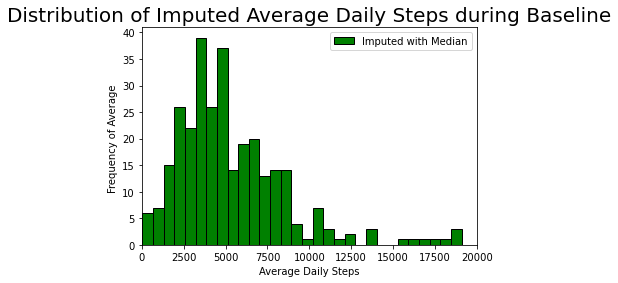

In [449]:
#plt.hist(baseline_df["Mean with values"], density=True)
num_bins = 30
plt.hist(b_median_impute_df["Baseline Average Steps Per Day"], num_bins, density=False, label = "Imputed with Median", color = "green",
                                edgecolor='k')
                            
plt.title('Distribution of Imputed Average Daily Steps during Baseline', fontsize=20)
plt.xlabel(r'Average Daily Steps')
plt.ylabel(r'Frequency of Average ')
plt.xlim([0, 20000]) 
plt.legend(loc='upper right')

In [450]:
mean_with_medianimpute = round(b_median_impute_df["Baseline Average Steps Per Day"].mean(), 3)
var_with_medianimpute = round(b_median_impute_df["Baseline Average Steps Per Day"].var(), 3)
sd_with_medianimpute = round(b_median_impute_df["Baseline Average Steps Per Day"].std(),3)
#median_with_values = round(baseline_df["Median with values"].median(), 3)
print("Mean, variance, and standard error of this distribution are:")
print("Mean: " + str(mean_with_medianimpute))
print("Variance: " + str(var_with_medianimpute))
print("Standard Deviation: " + str(sd_with_medianimpute))

Mean, variance, and standard error of this distribution are:
Mean: 5326.199
Variance: 11094438.261
Standard Deviation: 3330.831


In [451]:
print("Absolute difference in mean: " + str(np.abs(mean_with_medianimpute - mean_with_values)))
print("Absolute difference in variance: " + str(np.abs(var_with_medianimpute - var_with_values)))
print("Absolute difference in standard deviation: " + str(np.abs(sd_with_medianimpute - sd_with_values)))

Absolute difference in mean: 413.34400000000005
Absolute difference in variance: 1427404.9289999995
Absolute difference in standard deviation: 207.7909999999997


## Contest Data

As before, we will first calculate the number of missing values in contest data and visualize them to see if any patterns emerge. 

In [483]:
contest_df = step_dataraw.loc[:, "6/1/23" : "8/31/23"]#subset the data by contest months
c_missing_per_column = contest_df.isna().sum()
print("Missing values per column:\n", c_missing_per_column)

Missing values per column:
 2023-06-01      1
2023-06-02     10
2023-06-03     15
2023-06-04     18
2023-06-05     25
             ... 
2023-08-27    199
2023-08-28    202
2023-08-29    209
2023-08-30    208
2023-08-31    256
Length: 92, dtype: int64


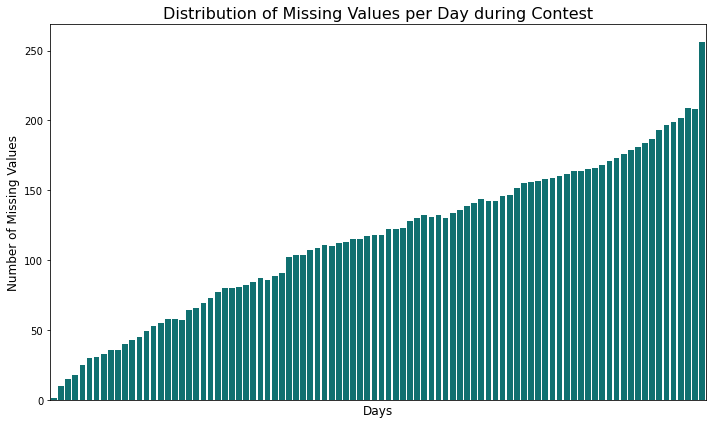

In [476]:
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(x=c_missing_per_column.index, y=c_missing_per_column.values, color='teal')

# Add titles and labels
plt.title('Distribution of Missing Values per Day during Contest', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Number of Missing Values', fontsize=12)
plt.xticks([], [])


# Rotate x-axis labels for better readability
#plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

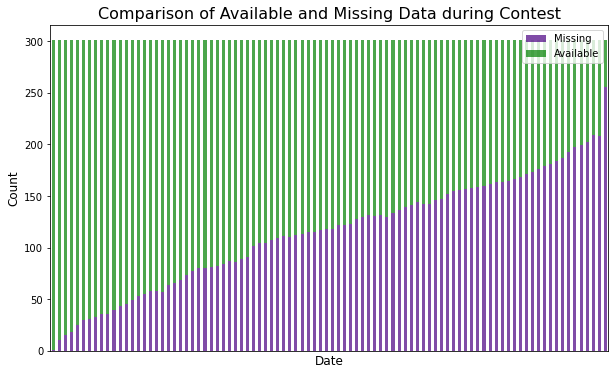

In [477]:
c_notmissing_per_column = contest_df.notna().sum() #calculate total available values per day
#print("Available values per column:\n", b_notmissing_per_column)

c_missing_df = pd.DataFrame({      #create a df with count of missing and available values
    'Missing': c_missing_per_column,
    'Available': c_notmissing_per_column
})

c_missing_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['indigo', 'green'], alpha=0.7) 


plt.title('Comparison of Available and Missing Data during Contest', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([], [])
plt.legend(['Missing', 'Available'], loc='upper right')
plt.show()

Every date in the contest period has missing values
The number of missing values steadily increase from the start of the contest to the end. 
The proportion of missing to available is greater than 50% toward the end of the contest
The days with the highest number of missing values fall in the last month of contest 
Imputation can result in “inventing” data and skew analysis


#### Contest Row Averages of Daily Steps with Available Values 

We will now calculate the average number of daily steps by dividing the sum of available values in the row observations with the number of days in the contest period. We then visualize the distribution of averages and get the moments of distribution.  

In [478]:
contest_df["Mean with values"] = (contest_df.sum(axis=1) /contest_df.shape[1]).round(3) 

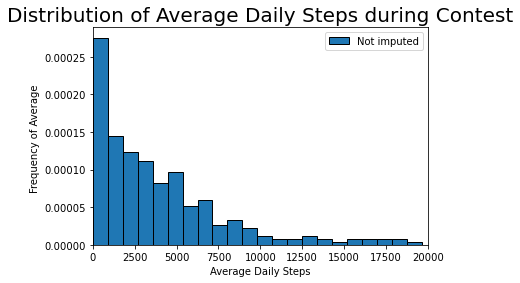

In [479]:
#plt.hist(baseline_df["Mean with values"], density=True)
num_bins = 30
count, bins, ignored = plt.hist(contest_df["Mean with values"], num_bins, density=True, label = "Not imputed",
                                edgecolor='k')
                            
plt.title('Distribution of Average Daily Steps during Contest', fontsize=20)
plt.xlabel(r'Average Daily Steps')
plt.ylabel(r'Frequency of Average ')
plt.xlim([0, 20000])
plt.legend(loc='upper right')

In [480]:
mean_with_values = round(contest_df["Mean with values"].mean(), 1)
var_with_values = round(contest_df["Mean with values"].var(), 1)
sd_with_values = round(contest_df["Mean with values"].std(),1)

print("Mean: " + str(mean_with_values))
print("Variance: " + str(var_with_values))
print("Standard Deviation: " + str(std_error_with_values))

Mean: 4037.0
Variance: 18876209.1
Standard Deviation: 4060.841


#### Imputing Missing Data with Mean

This method uses the row mean to fill in the missing values for each observation. In other words, we use the individual's average daily number of steps during the contest period to fill the values for days with missing data.

In [482]:
c_mean_impute_df = contest_df.copy()
c_mean_impute_df.columns

Index([2023-06-01 00:00:00, 2023-06-02 00:00:00, 2023-06-03 00:00:00,
       2023-06-04 00:00:00, 2023-06-05 00:00:00, 2023-06-06 00:00:00,
       2023-06-07 00:00:00, 2023-06-08 00:00:00, 2023-06-09 00:00:00,
       2023-06-10 00:00:00, 2023-06-11 00:00:00, 2023-06-12 00:00:00,
       2023-06-13 00:00:00, 2023-06-14 00:00:00, 2023-06-15 00:00:00,
       2023-06-16 00:00:00, 2023-06-17 00:00:00, 2023-06-18 00:00:00,
       2023-06-19 00:00:00, 2023-06-20 00:00:00, 2023-06-21 00:00:00,
       2023-06-22 00:00:00, 2023-06-23 00:00:00, 2023-06-24 00:00:00,
       2023-06-25 00:00:00, 2023-06-26 00:00:00, 2023-06-27 00:00:00,
       2023-06-28 00:00:00, 2023-06-29 00:00:00, 2023-06-30 00:00:00,
       2023-07-01 00:00:00, 2023-07-02 00:00:00, 2023-07-03 00:00:00,
       2023-07-04 00:00:00, 2023-07-05 00:00:00, 2023-07-06 00:00:00,
       2023-07-07 00:00:00, 2023-07-08 00:00:00, 2023-07-09 00:00:00,
       2023-07-10 00:00:00, 2023-07-11 00:00:00, 2023-07-12 00:00:00,
       2023-07-13 00

In [467]:
c_mean_impute_df.isna()

,2023-06-01 00:00:00,2023-06-02 00:00:00,2023-06-03 00:00:00,2023-06-04 00:00:00,2023-06-05 00:00:00,2023-06-06 00:00:00,2023-06-07 00:00:00,2023-06-08 00:00:00,2023-06-09 00:00:00,2023-06-10 00:00:00,...,2023-08-23 00:00:00,2023-08-24 00:00:00,2023-08-25 00:00:00,2023-08-26 00:00:00,2023-08-27 00:00:00,2023-08-28 00:00:00,2023-08-29 00:00:00,2023-08-30 00:00:00,2023-08-31 00:00:00,Mean with values
0,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
297,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
298,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,False
299,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
